In [14]:
!git clone https://github.com/ChiThanh512/Machine-Learning-Project-251---CEML1.git

fatal: destination path 'Machine-Learning-Project-251---CEML1' already exists and is not an empty directory.


In [15]:
# ============================================================
# CELL 1: KIỂM TRA GPU + CÀI THƯ VIỆN CẦN THIẾT
# - Colab thường có GPU T4. Nếu không có, vào Runtime -> Change runtime type -> GPU
# - Cài torch/torchvision + scikit-learn + matplotlib + pandas + h5py (để lưu đặc trưng nếu muốn)
# - Cài kaggle để tải dataset trực tiếp trong Colab
# ============================================================
import sys, subprocess, pkgutil

def pip_install(pkgs):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", *pkgs], check=True)

pip_install(["kaggle", "torch", "torchvision", "torchaudio", "scikit-learn", "matplotlib", "pandas", "h5py"])

import torch, torchvision
print("PyTorch:", torch.__version__, "| TorchVision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


PyTorch: 2.8.0+cu126 | TorchVision: 0.23.0+cu126
CUDA available: False


In [16]:
# ============================================================
# CELL 2: THAM SỐ CHUNG & RANDOM SEED
# - Giúp tái lập kết quả giữa các lần chạy
# - Bạn có thể chỉnh các biến cấu hình ở đây (EPOCHS, BATCH_SIZE, BACKBONE, ...)
# ============================================================
import os, random, numpy as np
from pathlib import Path

SEED = 42
random.seed(SEED); np.random.seed(SEED)
import torch
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Cấu hình pipeline
IMG_SIZE = 224                # kích thước ảnh đưa vào model
BATCH_SIZE = 64               # giảm nếu OOM (32/16)
NUM_WORKERS = 2               # số worker dataloader (2 cho Colab là an toàn)
BACKBONE_FE = "resnet50"      # backbone cho TRÍCH ĐẶC TRƯNG: ["resnet18","resnet50","efficientnet_b0","vit_b_16"]
USE_PCA = True                # có dùng PCA khi train model truyền thống hay không
PCA_KEEP = 0.95               # giữ 95% phương sai
RUN_DL = True                 # có chạy phần deep learning fine-tune hay không

# Thư mục làm việc trong Colab (chưa push GitHub vội, chạy xong rồi hãy git push)
PROJECT_ROOT = Path("/content/Machine-Learning-Project-251---CEML1/BTL3")  # bạn có thể đổi thành đường dẫn repo đã git clone
DATA_ROOT = PROJECT_ROOT / "raw_data"
FEATURES_DIR = PROJECT_ROOT / "features"
REPORTS_DIR = PROJECT_ROOT / "reports"
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"
for p in [DATA_ROOT, FEATURES_DIR, REPORTS_DIR, NOTEBOOKS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)


Using device: cpu
Project root: /content/Machine-Learning-Project-251---CEML1/BTL3


In [17]:
# ============================================================
# CELL 3: TẢI DATASET KAGGLE "l3llff/flowers"
# - LẦN ĐẦU: bạn cần upload file kaggle.json (API Token) của tài khoản Kaggle
#   Cách lấy: Kaggle -> Account -> Create New API Token
# - Code sẽ tải zip về, giải nén, và cố gắng nhận diện đúng thư mục ảnh
# ============================================================
from google.colab import files
import zipfile, shutil, glob

# B1) đảm bảo đã có ~/.kaggle/kaggle.json
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("👉 Vui lòng upload kaggle.json")
    up = files.upload()  # chọn kaggle.json
    assert 'kaggle.json' in up, "Thiếu kaggle.json!"
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)

# B2) tải dataset
DATASET_REF = "l3llff/flowers"
!kaggle datasets download -d {DATASET_REF} -p {str(DATA_ROOT)} -q

# B3) giải nén tất cả .zip vào DATA_ROOT
for z in list(DATA_ROOT.glob("*.zip")):
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(DATA_ROOT)
    z.unlink()

# B4) tìm thư mục chứa nhiều ảnh nhất và coi như DATA_DIR
cands = [p for p in DATA_ROOT.glob("*") if p.is_dir()]
def count_images(path):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    return sum(len(list(path.rglob(e))) for e in exts)

cands_sorted = sorted(cands, key=count_images, reverse=True)
assert cands_sorted, "Không tìm được thư mục ảnh sau giải nén!"
DATA_DIR = cands_sorted[0]
print("DATA_DIR =", DATA_DIR, "| #images:", count_images(DATA_DIR))


Dataset URL: https://www.kaggle.com/datasets/l3llff/flowers
License(s): CC0-1.0
DATA_DIR = /content/Machine-Learning-Project-251---CEML1/BTL3/raw_data/flowers | #images: 15740


In [18]:
# ============================================================
# CELL 4: NẠP DANH SÁCH ẢNH + NHÃN
# - Hỗ trợ 2 kiểu:
#    (A) folder-per-class: DATA_DIR/<class>/*.jpg
#    (B) có labels.csv: cột 'file' + 'label' (code sẽ tự đoán tên cột nếu khác)
# - Kết quả:
#    image_paths: list[str], image_labels: list[int], class_names: list[str]
# ============================================================
import pandas as pd
from pathlib import Path

labels_csv = DATA_DIR/'labels.csv'
image_paths, image_labels = [], []

if labels_csv.exists():
    df = pd.read_csv(labels_csv)
    file_col  = 'file'  if 'file'  in df.columns else df.columns[0]
    label_col = 'label' if 'label' in df.columns else df.columns[1]
    img_root = DATA_DIR
    for cand in ['images','imgs','image','data']:
        if (DATA_DIR/cand).exists():
            img_root = DATA_DIR/cand; break
    class_names = sorted(df[label_col].unique().tolist())
    class_to_idx = {c:i for i,c in enumerate(class_names)}
    for _,row in df.iterrows():
        fp = img_root/row[file_col]
        if fp.exists():
            image_paths.append(str(fp))
            image_labels.append(class_to_idx[row[label_col]])
else:
    # Kiểu folder-per-class
    subdirs = [d for d in DATA_DIR.glob("*") if d.is_dir()]
    subdirs = [d for d in subdirs if count_images(d) > 0]
    class_names = sorted([d.name for d in subdirs])
    class_to_idx = {c:i for i,c in enumerate(class_names)}
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    for cls in class_names:
        for ext in exts:
            for fp in (DATA_DIR/cls).rglob(ext):
                image_paths.append(str(fp))
                image_labels.append(class_to_idx[cls])

image_paths = np.array(image_paths); image_labels = np.array(image_labels)
NUM_CLASSES = len(class_names)
print(f"Số lớp: {NUM_CLASSES} -> {class_names[:10]}{'...' if NUM_CLASSES>10 else ''}")
print("Tổng số ảnh:", len(image_paths))
assert len(image_paths) == len(image_labels) and len(image_paths) > 0


Số lớp: 16 -> ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion']...
Tổng số ảnh: 15740


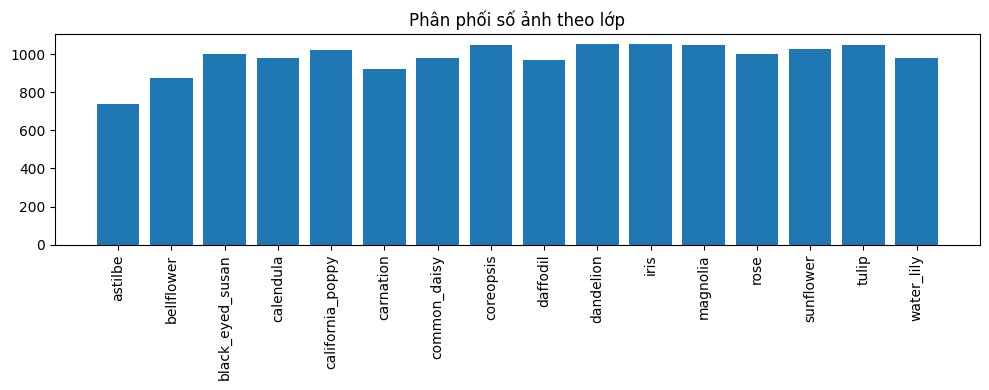

Kích thước ảnh (W,H): mean [256. 256.] | min [256 256] | max [256 256]


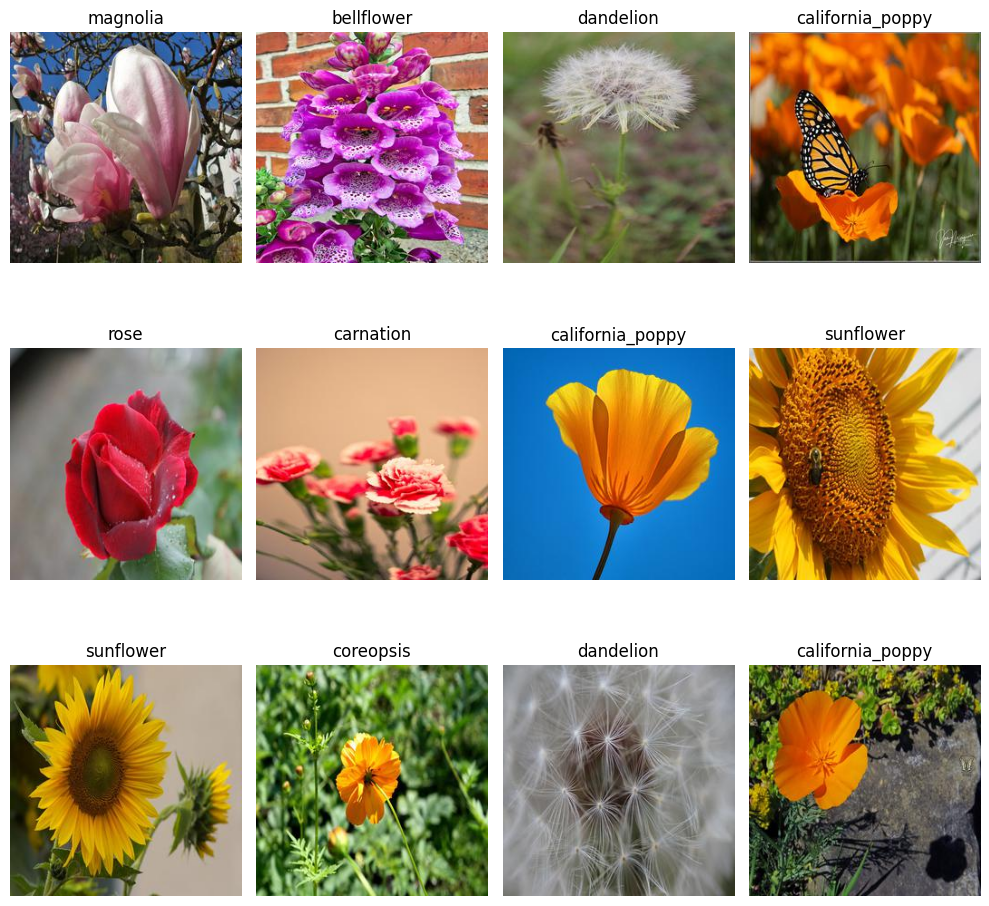

In [19]:
# ============================================================
# CELL 5: EDA NHANH
# - Vẽ phân phối số ảnh theo lớp
# - Thống kê kích thước ảnh (lấy mẫu 300 ảnh)
# - Hiển thị 12 ảnh ngẫu nhiên
# ============================================================
import matplotlib.pyplot as plt
from PIL import Image

# Phân phối nhãn
label_counts = pd.Series(image_labels).value_counts().sort_index()
plt.figure(figsize=(10,4))
plt.bar(range(NUM_CLASSES), label_counts.values)
plt.xticks(range(NUM_CLASSES), class_names, rotation=90)
plt.title("Phân phối số ảnh theo lớp")
plt.tight_layout(); plt.show()

# Thống kê kích thước ảnh (lấy tối đa 300 ảnh để nhanh)
sizes = []
for p in image_paths[:min(300, len(image_paths))]:
    with Image.open(p) as im:
        sizes.append(im.size)  # (W,H)
sizes = np.array(sizes)
print("Kích thước ảnh (W,H): mean", sizes.mean(axis=0), "| min", sizes.min(axis=0), "| max", sizes.max(axis=0))

# Hiển thị 12 ảnh bất kỳ
plt.figure(figsize=(10,10))
idxs = np.random.choice(len(image_paths), size=min(12, len(image_paths)), replace=False)
for i,ix in enumerate(idxs,1):
    plt.subplot(3,4,i); plt.axis('off')
    plt.title(class_names[image_labels[ix]])
    plt.imshow(Image.open(image_paths[ix]))
plt.tight_layout(); plt.show()


In [20]:
# ============================================================
# CELL 6: CHIA TẬP STRATIFIED 80/10/10 (train/val/test)
# - Dùng StratifiedShuffleSplit để giữ cân bằng tỉ lệ lớp giữa các tập
# ============================================================
from sklearn.model_selection import StratifiedShuffleSplit

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)  # 80% train, 20% tạm
train_idx, temp_idx = next(sss1.split(image_paths, image_labels))
X_train, y_train = image_paths[train_idx], image_labels[train_idx]
X_temp,  y_temp  = image_paths[temp_idx],  image_labels[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)  # 10% val, 10% test
val_idx, test_idx = next(sss2.split(X_temp, y_temp))
X_val,  y_val  = X_temp[val_idx],  y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

print(f"Split => train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")


Split => train: 12592, val: 1574, test: 1574


In [21]:
# ============================================================
# CELL 7: TẠO DATASET & TRANSFORM CHO PYTORCH
# - fe_tfm: dùng cho TRÍCH ĐẶC TRƯNG (resize + normalize theo ImageNet)
# - train_tfms/val_tfms: dùng cho DEEP LEARNING fine-tune (có augment)
# - FileListDS: dataset đọc ảnh từ đường dẫn
# ============================================================
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

IMG_SIZE_FE = IMG_SIZE  # dùng chung kích thước

fe_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE_FE, IMG_SIZE_FE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class FileListDS(Dataset):
    """Dataset đơn giản đọc ảnh từ list đường dẫn."""
    def __init__(self, paths, labels, tfm):
        self.paths = list(paths); self.labels = list(labels); self.tfm = tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        from PIL import Image
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        img = self.tfm(img)
        return img, self.labels[idx]

# (Dataloader cho DEEP LEARNING sẽ tạo sau)


In [22]:
# ============================================================
# CELL 8: XÂY FEATURE EXTRACTOR TỪ MODEL PRETRAINED
# - Thay "head" cuối bằng Identity để lấy vector đặc trưng
# - Hỗ trợ resnet18 / resnet50 / efficientnet_b0 / vit_b_16
# ============================================================
import torch.nn as nn
from torchvision import models

def build_feature_extractor(backbone):
    if backbone == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        dim = m.fc.in_features
        m.fc = nn.Identity()
    elif backbone == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        dim = m.fc.in_features
        m.fc = nn.Identity()
    elif backbone == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        dim = m.classifier[-1].in_features
        m.classifier[-1] = nn.Identity()
    elif backbone == "vit_b_16":
        m = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        dim = m.heads.head.in_features
        m.heads.head = nn.Identity()
    else:
        raise ValueError("Unknown backbone:", backbone)
    return m.to(DEVICE).eval(), dim


In [ ]:
# ============================================================
# CELL 9: TRÍCH ĐẶC TRƯNG -> NUMPY -> LƯU .NPY
# - Dùng autocast (AMP) để nhanh và tiết kiệm VRAM
# - Lưu ra thư mục /content/BTL3/features để sau này train nhanh
# ============================================================
@torch.no_grad()
def extract_numpy_features(paths, labels, backbone, batch=BATCH_SIZE, num_workers=NUM_WORKERS):
    ds = FileListDS(paths, labels, fe_tfm)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=num_workers, pin_memory=True)
    fe, dim = build_feature_extractor(backbone)
    feats = np.zeros((len(ds), dim), dtype=np.float32)
    lbs   = np.zeros((len(ds),), dtype=np.int64)
    idx = 0
    for imgs, gts in dl:
        imgs = imgs.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(True):
            v = fe(imgs)          # (B, dim)
        v = v.detach().float().cpu().numpy()
        b = v.shape[0]
        feats[idx:idx+b] = v
        lbs[idx:idx+b]   = gts.numpy()
        idx += b
    return feats, lbs

train_feat, train_lbs = extract_numpy_features(X_train, y_train, BACKBONE_FE)
val_feat,   val_lbs   = extract_numpy_features(X_val,   y_val,   BACKBONE_FE)
test_feat,  test_lbs  = extract_numpy_features(X_test,  y_test,  BACKBONE_FE)

np.save(FEATURES_DIR/f"train_{BACKBONE_FE}.npy", train_feat)
np.save(FEATURES_DIR/f"val_{BACKBONE_FE}.npy",   val_feat)
np.save(FEATURES_DIR/f"test_{BACKBONE_FE}.npy",  test_feat)
np.save(FEATURES_DIR/"train_labels.npy", train_lbs)
np.save(FEATURES_DIR/"val_labels.npy",   val_lbs)
np.save(FEATURES_DIR/"test_labels.npy",  test_lbs)

print("✔ Đã lưu đặc trưng vào:", FEATURES_DIR)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-627964472.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
# ============================================================
# CELL 10: TRAIN MÔ HÌNH TRUYỀN THỐNG TRÊN FEATURE
# - So sánh 3 mô hình: Logistic Regression, SVM(RBF), RandomForest
# - Pipeline: StandardScaler -> (PCA) -> Classifier
# - Đánh giá bằng Accuracy và Macro-F1 (cân bằng lớp)
# ============================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

def make_pipe(base_estimator):
    steps = [("scaler", StandardScaler())]
    if USE_PCA:
        steps.append(("pca", PCA(n_components=PCA_KEEP, svd_solver="full")))
    steps.append(("clf", base_estimator))
    return SkPipeline(steps)

def evaluate_clf(name, clf, Xtr, ytr, Xva, yva, Xte, yte):
    clf.fit(Xtr, ytr)
    va_pred = clf.predict(Xva)
    te_pred = clf.predict(Xte)
    va_acc = accuracy_score(yva, va_pred); va_f1 = f1_score(yva, va_pred, average="macro")
    te_acc = accuracy_score(yte, te_pred); te_f1 = f1_score(yte, te_pred, average="macro")
    print(f"[{name}]  Val Acc {va_acc:.4f} | Val F1 {va_f1:.4f}  ||  Test Acc {te_acc:.4f} | Test F1 {te_f1:.4f}")
    return te_pred, (va_f1, te_f1)

# Khởi tạo 3 model
lr  = make_pipe(LogisticRegression(max_iter=500, C=1.0))
svm = make_pipe(SVC(C=2.0, gamma="scale", kernel="rbf"))
rf  = make_pipe(RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=SEED))

print("=== TRAINING CLASSICAL MODELS ON PRETRAINED FEATURES ===")
pred_lr,  sc_lr  = evaluate_clf("LogReg",     lr,  train_feat, train_lbs, val_feat, val_lbs, test_feat, test_lbs)
pred_svm, sc_svm = evaluate_clf("SVM-RBF",    svm, train_feat, train_lbs, val_feat, val_lbs, test_feat, test_lbs)
pred_rf,  sc_rf  = evaluate_clf("RandomForest", rf, train_feat, train_lbs, val_feat, val_lbs, test_feat, test_lbs)

# Chọn model tốt nhất theo Macro-F1 trên VAL -> report chi tiết trên TEST
scores = {"LogReg": sc_lr[0], "SVM-RBF": sc_svm[0], "RandomForest": sc_rf[0]}
best_name = max(scores, key=scores.get)
best_model = {"LogReg": lr, "SVM-RBF": svm, "RandomForest": rf}[best_name]
best_model.fit(np.vstack([train_feat, val_feat]), np.concatenate([train_lbs, val_lbs]))
test_pred = best_model.predict(test_feat)
print(f"\n=> Best on VAL (macro-F1): {best_name}")
print("\n=== CLASSIFICATION REPORT (TEST) ===")
print(classification_report(test_lbs, test_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(test_lbs, test_pred)
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix - {best_name}")
plt.colorbar()
tick = np.arange(NUM_CLASSES)
plt.xticks(tick, class_names, rotation=90); plt.yticks(tick, class_names)
plt.tight_layout(); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()


In [ ]:
# ============================================================
# CELL 11 (NEW): DEEP LEARNING FINE-TUNE + LEARNING CURVES
# - Train ResNet18 (pretrained) với AMP + EarlyStopping
# - Ghi lại lịch sử train/val (loss, acc, macro-F1) để vẽ curve
# - Lưu best model vào PROJECT_ROOT/"best_dl_model.pth"
# ============================================================
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import time, math
import matplotlib.pyplot as plt

if RUN_DL:
    # 1) Dataloader cho DL (dùng transforms đã tạo từ trước: train_tfms, val_tfms)
    train_ds = FileListDS(X_train, y_train, train_tfms)
    val_ds   = FileListDS(X_val,   y_val,   val_tfms)
    test_ds  = FileListDS(X_test,  y_test,  val_tfms)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # 2) Model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)

    # Freeze backbone 2 epoch đầu → học head trước
    for name, p in model.named_parameters():
        p.requires_grad = ("fc" in name)

    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)

    EPOCHS = 40           # <-- bạn có thể tăng 50/80 tùy ý
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=True)

    from sklearn.metrics import accuracy_score, f1_score

    # 3) Hàm chạy 1 epoch và trả về (loss, acc, f1)
    def run_epoch(loader, train_mode=True):
        model.train(train_mode)
        allp, allg = [], []
        running = 0.0
        for x,y in loader:
            x=x.to(DEVICE); y=y.to(DEVICE)
            with torch.cuda.amp.autocast(True):
                logits = model(x)
                loss = criterion(logits, y)
            if train_mode:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
            running += loss.item()*x.size(0)
            pred = logits.argmax(1)
            allp.extend(pred.detach().cpu().numpy().tolist())
            allg.extend(y.detach().cpu().numpy().tolist())
        epoch_loss = running/len(loader.dataset)
        acc = accuracy_score(allg, allp)
        f1  = f1_score(allg, allp, average="macro")
        return epoch_loss, acc, f1

    # 4) Lịch sử để vẽ learning curves
    history = {"epoch":[], "tr_loss":[], "tr_acc":[], "tr_f1":[],
               "val_loss":[], "val_acc":[], "val_f1":[]}

    best_f1, best_state = -1, None
    patience, PATIENCE = 0, 6

    for epoch in range(1, EPOCHS+1):
        # Unfreeze backbone từ epoch 3
        if epoch == 3:
            for p in model.parameters(): p.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS-epoch+1)
            print("[Info] Unfroze backbone at epoch 3.")

        t0 = time.time()
        tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, True)
        va_loss, va_acc, va_f1 = run_epoch(val_loader,   False)
        scheduler.step()

        history["epoch"].append(epoch)
        history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc); history["tr_f1"].append(tr_f1)
        history["val_loss"].append(va_loss); history["val_acc"].append(va_acc); history["val_f1"].append(va_f1)

        print(f"Epoch {epoch:02d}/{EPOCHS} | "
              f"Train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} | "
              f"Val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} | "
              f"time {time.time()-t0:.1f}s")

        # Early stopping theo macro-F1 (val)
        if va_f1 > best_f1:
            best_f1 = va_f1
            best_state = model.state_dict()
            torch.save(best_state, PROJECT_ROOT/"best_dl_model.pth")
            patience = 0
        else:
            patience += 1
            if patience >= PATIENCE:
                print("[EarlyStopping] Stop.")
                break

    # 5) VẼ LEARNING CURVES (Loss / Accuracy / Macro-F1)
    REPORTS_DIR.mkdir(parents=True, exist_ok=True)
    (REPORTS_DIR/"graphics").mkdir(parents=True, exist_ok=True)

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["tr_loss"], label="train")
    plt.plot(history["epoch"], history["val_loss"], label="val")
    plt.title("Learning Curve - Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.tight_layout(); plt.show()
    plt.savefig(REPORTS_DIR/"graphics/lc_loss.png")

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["tr_acc"], label="train")
    plt.plot(history["epoch"], history["val_acc"], label="val")
    plt.title("Learning Curve - Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout(); plt.show()
    plt.savefig(REPORTS_DIR/"graphics/lc_acc.png")

    # Macro-F1
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["tr_f1"], label="train")
    plt.plot(history["epoch"], history["val_f1"], label="val")
    plt.title("Learning Curve - Macro-F1"); plt.xlabel("Epoch"); plt.ylabel("Macro-F1"); plt.legend()
    plt.tight_layout(); plt.show()
    plt.savefig(REPORTS_DIR/"graphics/lc_f1.png")

    # 6) Đánh giá TEST bằng best model
    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    allp, allg = [], []
    with torch.inference_mode():
        for x,y in test_loader:
            x=x.to(DEVICE); y=y.to(DEVICE)
            p = model(x).argmax(1)
            allp.extend(p.cpu().numpy().tolist()); allg.extend(y.cpu().numpy().tolist())
    te_acc = accuracy_score(allg,allp); te_f1 = f1_score(allg,allp,average="macro")
    print(f"[DEEP] Test Acc {te_acc:.4f} | Test Macro-F1 {te_f1:.4f}")
else:
    print("RUN_DL = False -> Bỏ qua phần deep learning.")


In [ ]:
# ============================================================
# CELL 12: HIỂN THỊ DỰ ĐOÁN MẪU (ảnh + nhãn thật + nhãn dự đoán + độ tự tin)
# - Chạy sau khi Cell 11 train DL xong (đã có 'model' và 'test_ds')
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

# Helper: denormalize tensor (do ta normalize theo ImageNet)
IM_MEAN = np.array([0.485, 0.456, 0.406])
IM_STD  = np.array([0.229, 0.224, 0.225])
def denorm_img(t):
    x = t.detach().cpu().numpy()
    # x shape: (C,H,W)
    x = x.transpose(1,2,0) * IM_STD + IM_MEAN
    x = np.clip(x, 0, 1)
    return x

def show_predictions_dl(dataset, model, n=8):
    model.eval()
    n = min(n, len(dataset))
    idxs = np.random.choice(len(dataset), size=n, replace=False)
    cols = 4
    rows = int(math.ceil(n/cols))
    plt.figure(figsize=(4*cols, 3.5*rows))

    with torch.inference_mode():
        for i,ix in enumerate(idxs, 1):
            img, y = dataset[ix]
            logits = model(img.unsqueeze(0).to(DEVICE))
            probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
            pred = int(probs.argmax()); conf = float(probs[pred])

            plt.subplot(rows, cols, i)
            plt.imshow(denorm_img(img))
            title = f"Pred: {class_names[pred]} ({conf:.2f})\nTrue: {class_names[y]}"
            color = "green" if pred==y else "red"
            plt.title(title, color=color, fontsize=11)
            plt.axis("off")
    plt.tight_layout(); plt.show()

# Hiển thị 12 ảnh dự đoán mẫu từ tập test
show_predictions_dl(test_ds, model, n=12)
